In [1]:
import sys, os, pickle

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from itertools import product

from maxent import compute_expected_causal_svf

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

[0.4 0.6 1. ]


In [2]:
def to_one_hot_array(input_array, num_unique_values=4):
  one_hot_array = np.zeros((len(input_array), num_unique_values), dtype=int)

  for i, val in enumerate(input_array):
    one_hot_array[i, val] = 1

  return one_hot_array

# Load MIMIC Data

In [3]:
# if re_split:


aggr_df = pd.read_csv('mimic_iv_hypotensive_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
# create action bins (four actions in total)
aggr_df['action'] = aggr_df['bolus(binary)']*2 + aggr_df['vaso(binary)']
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
# print (np.unique(train_df['action'],return_counts=True)[1]*1./len(train_df))
# pickle.dump([train_df, test_df, valid_df], open(data_save_path+'processed_mimic_hyp_2.pkl','wb'))
drop_columns = ['vaso(amount)','bolus(amount)',\
            'any_treatment(binary)','vaso(binary)','bolus(binary)']




In [34]:
aggr_df

creatinine   
stay_id  time                                                     
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)         NaN  \
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)         2.7   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)         NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)         NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)         NaN   
...                                                         ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)         NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)         NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)         NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)         NaN   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)         NaN   

                                                     fraction_inspired_oxygen   
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN  \
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                       NaN   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   
...                                                                       ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)                       NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)                       NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)                       NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)                       0.8   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)                       NaN   

                                                     lactate  urine_output   
stay_id  time                                                                
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)      NaN           NaN  \
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)      NaN          40.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)      NaN         100.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)      1.7           NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)      NaN          40.0   
...                                                      ...           ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)      NaN          80.0   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)      NaN           NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)      NaN           NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)      NaN         150.0   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)      NaN         100.0   

                                                     alanine_aminotransferase   
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN  \
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      38.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   
...                                                                       ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)                       NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)                       NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)                       NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)                       NaN   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)                       NaN   

                                                     aspar

# Data Cleaning

In [4]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


#### standard normalization ####
normalize_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen']
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [5]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()

# UMAP

In [12]:
x_df_numpy = X_df.to_numpy()
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(x_df_numpy)

/Users/iliang/Library/Python/3.8/lib/python/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


/var/folders/rn/scy6ltdn1374gwc_l7grnh1w0000gp/T/ipykernel_8283/2870882227.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df, palette='viridis', s=70)


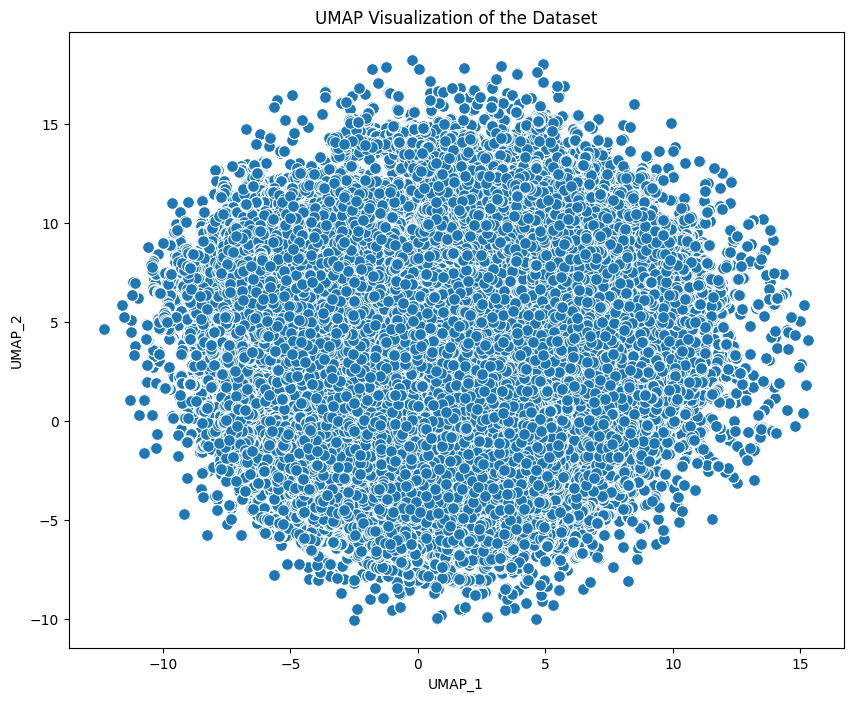

In [18]:
umap_df = pd.DataFrame(data=embedding, columns=['UMAP_1', 'UMAP_2'])
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df, palette='viridis', s=70)
plt.title("UMAP Visualization of the Dataset")
plt.show()

# Clustering (Kmeans)

In [11]:
num_clusters = 100
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)

/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=100, random_state=0)

In [12]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [13]:
x_df_numpy = X_df.to_numpy()
x_df_numpy

array([[-4.22007784e-01, -1.76074336e+00, -1.82521412e-01, ...,
         3.70000000e+01,  1.90000000e+01,  3.80000000e+01],
       [-4.22007784e-01, -1.76074336e+00, -1.82521412e-01, ...,
         3.70000000e+01,  1.90000000e+01,  3.80000000e+01],
       [-4.22007784e-01, -1.76074336e+00,  3.60531974e-01, ...,
         3.70000000e+01,  1.90000000e+01,  3.80000000e+01],
       ...,
       [ 7.39523541e-01, -6.06277971e-01, -4.99302553e-01, ...,
         3.68333333e+01,  2.20000000e+01,  2.00000000e+01],
       [ 7.39523541e-01,  1.33539053e-03, -5.44557002e-01, ...,
         3.67777778e+01,  2.90000000e+01,  4.00000000e+01],
       [ 7.39523541e-01,  1.33539053e-03, -5.44557002e-01, ...,
         3.67777778e+01,  2.10000000e+01,  3.80000000e+01]])

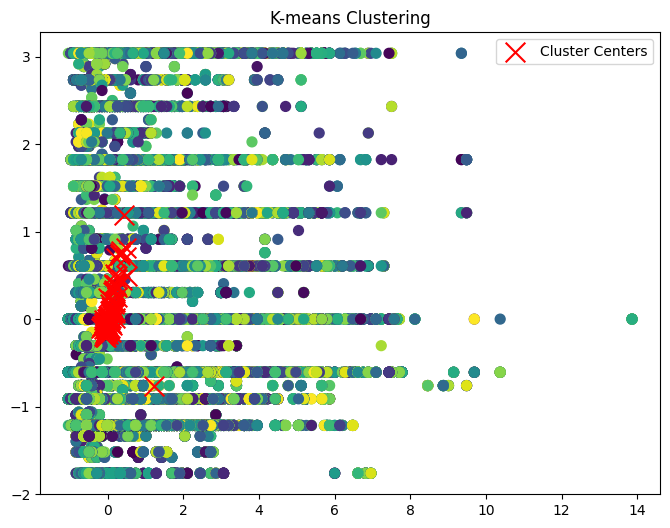

In [14]:
cluster_labels = kmeans.labels_

# Extract cluster centers (optional)
cluster_centers = kmeans.cluster_centers_

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Plot data points with color-coded clusters
plt.scatter(x_df_numpy[:, 0], x_df_numpy[:, 1], c=cluster_labels, cmap='viridis', s=50)

# Plot cluster centers (optional)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')

plt.title("K-means Clustering")
plt.legend()
plt.show()

In [22]:
x_df_numpy = X_df.to_numpy()
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(x_df_numpy)
umap_df = pd.DataFrame(data=embedding, columns=['UMAP_1', 'UMAP_2'])

KeyboardInterrupt: 

In [15]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='cluster', data=umap_df, palette='viridis', s=70)
plt.title("UMAP Visualization of the Dataset")
plt.show()

NameError: name 'umap_df' is not defined

<Figure size 1000x800 with 0 Axes>

# Converting the data into trajectories to input to an IRL algorithm

In [19]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  trajectories.append(T.Trajectory(trajectory))

In [20]:
# Store all possible terminal states from trajectory list
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

# MaxEnt Causal IRL Helper Functions

In [ ]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [ ]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

In [ ]:
def irl_causal(p_transition, features, terminal, trajectories, optim, init, discount,
               eps=1e-4, eps_svf=1e-5, eps_lap=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    all_rewards = []
    all_grads = []

    optim.reset(theta)
    while delta > eps:
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)
        all_rewards.append(reward)

        # compute the gradient
        e_svf = compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                            eps_lap, eps_svf)

        grad = e_features - features.T.dot(e_svf)
        all_grads.append(grad)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        print(grad.shape)
        delta = np.max(np.abs(theta_old - theta))

    # save all_rewards and all_grads to csv files, where each row corresponds to 1 step
    # UNCOMMENT this block of code if you want to save another run of rewards and grads
    
    # all_rewards = pd.DataFrame(all_rewards)
    # all_grads = pd.DataFrame(all_grads)
    # all_rewards.to_csv('all_rewards_maxent_causal.csv', index=False)
    # all_grads.to_csv('all_grads_maxent_causal.csv', index=False)

    # re-compute per-state reward and return
    return features.dot(theta)

# MaxEnt IRL Function

In [25]:
def feature_expectation_from_trajectories(features, trajectories):
    """
    Compute the feature expectation of the given trajectories.

    Simply counts the number of visitations to each feature-instance and
    divides them by the number of trajectories.

    Args:
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The feature-expectation of the provided trajectories as map
        `[state: Integer] -> feature_expectation: Float`.
    """
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        for s in t.states():
            fe += features[s, :]

    return fe / len(trajectories)


def initial_probabilities_from_trajectories(n_states, trajectories):
    """
    Compute the probability of a state being a starting state using the
    given trajectories.

    Args:
        n_states: The number of states.
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The probability of a state being a starting-state as map
        `[state: Integer] -> probability: Float`.
    """
    p = np.zeros(n_states)

    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0

    return p / len(trajectories)

def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    n_states, _, n_actions = p_transition.shape

    # 'fix' our transition probabilities to allow for convergence
    # we will _never_ leave any terminal state
    p_transition = np.copy(p_transition)
    p_transition[terminal, :, :] = 0.0

    # set-up transition matrices for each action
    p_transition = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # actual forward-computation of state expectations
    d = np.zeros(n_states)

    delta = np.inf
    while delta > eps:
        d_ = [p_transition[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.array(d_).sum(axis=0)

        delta, d = np.max(np.abs(d_ - d)), d_

    return d

def local_action_probabilities(p_transition, terminal, reward):
    n_states, _, n_actions = p_transition.shape

    er = np.exp(reward)
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # initialize at terminal states
    zs = np.zeros(n_states)
    zs[terminal] = 1.0

    # perform backward pass
    # This does not converge, instead we iterate a fixed number of steps. The
    # number of steps is chosen to reflect the maximum steps required to
    # guarantee propagation from any state to any other state and back in an
    # arbitrary MDP defined by p_transition.
    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)

    # compute local action probabilities
    return za / zs[:, None]

def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)

In [29]:
def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    all_rewards = []
    all_grads = []

    optim.reset(theta)
    while delta > eps:
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)
        all_rewards.append(reward)

        # compute the gradient
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)
        all_grads.append(grad)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
        # save all_rewards and all_grads to csv files, where each row corresponds to 1 step
    
    # UNCOMMENT this block of code if you want to save another run of rewards and grads
    all_rewards = pd.DataFrame(all_rewards)
    all_grads = pd.DataFrame(all_grads)
    all_rewards.to_csv('all_rewards_maxent.csv', index=False)
    all_grads.to_csv('all_grads_maxent.csv', index=False)

    # re-compute per-state reward and return
    return features.dot(theta)

In [17]:
smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, 4)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

# MaxEnt Causal Reward

In [22]:
# set up features: we use one feature vector per state
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])
state_onehot = state_encoder.fit(X_df['cluster'].to_numpy().reshape(-1, 1))
features = state_onehot.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.1))

discount = 0.9

# Computing the R function through inverse reinforcement learning
reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'irl_causal' is not defined

# MaxEnt Reward

In [30]:
# set up features: we use one feature vector per state
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])
state_onehot = state_encoder.fit(X_df['cluster'].to_numpy().reshape(-1, 1))
features = state_onehot.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.1))

discount = 0.9

# Computing the R function through inverse reinforcement learning
reward_maxent = irl(p_transition, features, terminal_states, trajectories, optim, init,
               eps=1e-4, eps_esvf=1e-5)

/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/iliang/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/rn/scy6ltdn1374gwc_l7grnh1w0000gp/T/ipykernel_18499/3883145130.py:87: RuntimeWarning: overflow encountered in multiply
  za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
/var/folders/rn/scy6ltdn1374gwc_l7grnh1w0000gp/T/ipykernel_18499/3883145130.py:91: RuntimeWarning: invalid value encountered in divide
  return za / zs[:, None]


# UMAP of Clusters

In [30]:
x_umap = X_df['cluster'].to_numpy()

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, n_features=10, centers=3, random_state=42)
# X: (300, 10)
# y: (300)

In [35]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(x_umap)

AttributeError: module 'umap' has no attribute 'UMAP'

In [33]:
reward_maxent_causal.shape

(100,)

In [29]:
f = pd.read_csv('all_grads.csv')
f.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.261152,0.858728,0.80131,1.042596,0.12409,0.426668,0.70988,0.19178,0.030811,0.338943,...,0.000334,0.4462,0.046806,0.814444,1.002186,0.523486,0.113148,0.502944,1.40057,1.307625
1,0.261152,0.858728,0.80131,1.042596,0.12409,0.426668,0.70988,0.19178,0.030811,0.338943,...,0.000334,0.4462,0.046806,0.814444,1.002186,0.523486,0.113148,0.502944,1.40057,1.307625
2,0.261152,0.858728,0.80131,1.042596,0.12409,0.426668,0.70988,0.19178,0.030811,0.338943,...,0.000334,0.4462,0.046806,0.814444,1.002186,0.523486,0.113148,0.502944,1.40057,1.307625
3,0.261152,0.858728,0.80131,1.042596,0.12409,0.426668,0.70988,0.19178,0.030811,0.338943,...,0.000334,0.4462,0.046806,0.814444,1.002186,0.523486,0.113148,0.502944,1.40057,1.307625
4,0.261152,0.858728,0.80131,1.042596,0.12409,0.426668,0.70988,0.19178,0.030811,0.338943,...,0.000334,0.4462,0.046806,0.814444,1.002186,0.523486,0.113148,0.502944,1.40057,1.307625
